<a href="https://colab.research.google.com/github/gurugeonu-02/gurugeonu-02/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EA%B8%B0%EC%B4%88_%EC%88%98%ED%96%89%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문제 추천(평가) AI 만들기
    - 딥러닝을 통해서 문제를 추천하는 모델을 만든다
    - 첫 번째로 푸는 게 적절하다 -> rating 5
    - 두 번째로 푸는 게 적절하다 -> rating 4
    - 세 번째로 푸는 게 적절하다 -> rating 3
    - 네 번째로 푸는 게 적절하다 -> rating 2
    - 다섯 번째로 푸는 게 적절하다 -> rating 1
    - 이런 식으로 rating을 부여하여 모델을 훈련시킨다
참고한 글: (https://lsjsj92.tistory.com/606)

In [186]:
# 기본 환경설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [187]:
# 데이터 준비
data = pd.read_csv('data/userratingdata.csv')
problems = pd.read_csv('data/problemdata.csv')

In [188]:
# 사용자가 어떤 문제를 풀었는지에 대한 데이터
print(data.shape)
data.head()

(260, 3)


,userid,problemid,rating
0,1,2,5
1,1,29,4
2,1,22,3
3,1,16,2
4,1,34,1


In [189]:
# 문제에 대한 정보
print(problems.shape)
problems.head()

(90, 7)


,problem,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,pid
0,2,0,30,7,0,1,1001
1,23,0,0,0,1,0,1100
2,20,1,0,1,0,0,1051
3,14,0,1,0,0,0,1018
4,25,1,0,0,0,0,1145


In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userid     260 non-null    int64
 1   problemid  260 non-null    int64
 2   rating     260 non-null    int64
dtypes: int64(3)
memory usage: 6.2 KB


In [191]:
problems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   problem    90 non-null     int64
 1   ratings_1  90 non-null     int64
 2   ratings_2  90 non-null     int64
 3   ratings_3  90 non-null     int64
 4   ratings_4  90 non-null     int64
 5   ratings_5  90 non-null     int64
 6   pid        90 non-null     int64
dtypes: int64(7)
memory usage: 5.0 KB


In [192]:
train, test = train_test_split(data, test_size = 0.2) # 훈련 데이터 80%, 테스트 데이터 20%로 나눠줌
print(train.shape, test.shape)
train.head()

(208, 3) (52, 3)


,userid,problemid,rating
63,13,51,2
259,52,67,1
49,10,10,1
116,24,1,4
166,34,30,4


In [193]:
number_of_unique_user = len(data.userid.unique())# 데이터에 있는 유저 수
number_of_unique_problems = len(data.problemid.unique())# 데이터에 있는 문제 수
print("유저 수:", number_of_unique_user, ", 문제 수:", number_of_unique_problems)

유저 수: 52 , 문제 수: 90


# Attempt 1
    간단한 Dot Product 형태의 모델
    사용자 embedding과 problemembedding을 기반으로 나온 벡터 값을 Dot 연산을 통해 rating을 예측하는 방법

In [194]:
# Layer 만들기
# 입력 레이어: 입력 받음
problem_input = Input(shape=(1,), name='problem_input_layer')
user_input = Input(shape=(1,), name='user_input_layer')

# embedding 레이어: 우리가 입력한 정보를 벡터 공간에 매핑
problem_embedding_layer = Embedding(number_of_unique_problems+1, 8, name='problem_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user+1, 8, name='user_embedding_layer')

# concate layer: 문제 벡터(problem vector)와 사용자 벡터(user vector)를 하나로 합쳐줌
concate_layer = Concatenate()

# Flatten: 벡터 차원을 하나 낮춰줌
problem_vector_layer = Flatten(name='problem_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')

# Dense layer: 데이터를 하나로 모으고 우리가 원하는 차원으로 축소시켜 표현
dense_layer1 = Dense(128, activation='relu')
dense_layer2 = Dense(32, activation='relu')

result_layer = Dense(1)

In [195]:
# Layer 쌓기
problem_embedding = problem_embedding_layer(problem_input)
user_embedding = user_embedding_layer(user_input)

problem_vector = problem_vector_layer(problem_embedding)
user_vector = user_vector_layer(user_embedding)

concat = concate_layer([problem_vector, user_vector])
dense1 = dense_layer1(concat)
dense2 = dense_layer2(dense1)

result = result_layer(dense2)

model = Model(inputs=[user_input, problem_input], outputs=result)

In [196]:
# 모델의 구조
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 problem_input_layer (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 user_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 problem_embedding_layer (Embed  (None, 1, 8)        728         ['problem_input_layer[0][0]']    
 ding)                                                                                            
                                                                                           

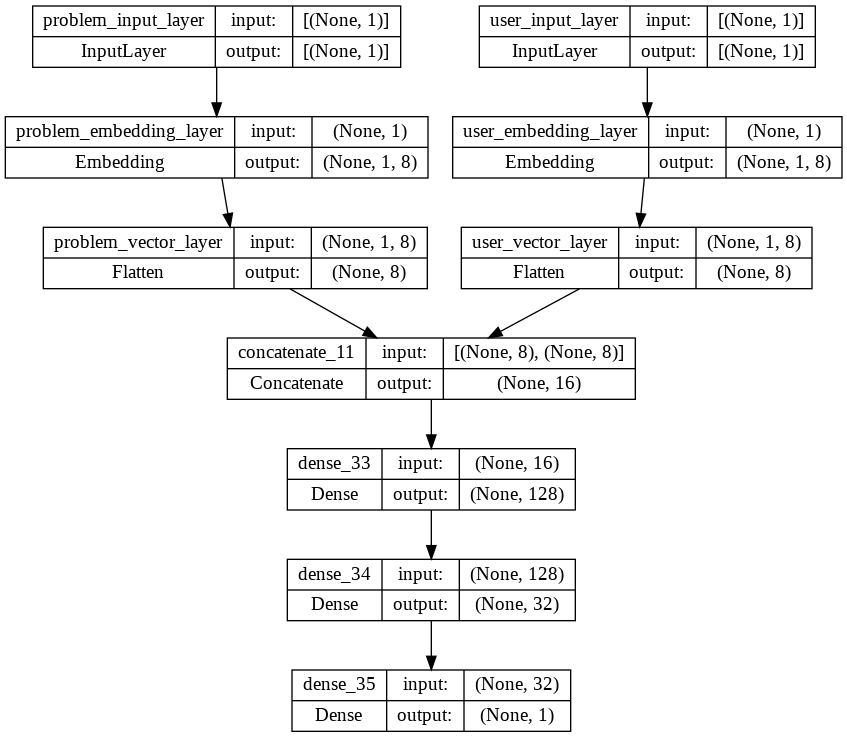

In [197]:
# 모델의 구조
plot_model(model, to_file='dense_layerl.png', show_shapes=True, show_layer_names=True)
# input layer -> embedding layer -> flatten layer -> concat layer -> dense layer -> result

In [198]:
# 모델 컴파일
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [199]:
# 모델 훈련시키기
x_train = [train.userid, train.problemid]# 모델 입력값
y_train= train.rating# 모델 출력값
history = model.fit(x_train, y_train, batch_size=10, epochs=32, verbose=True)
# 한번에 10개의 데이터씩 전체 데이터를 총 32번을 반복시켜서 훈련

Epoch 1/32
21/21 [==============================] - 1s 2ms/step - loss: 10.5809 - mse: 10.5809
Epoch 2/32
21/21 [==============================] - 0s 3ms/step - loss: 8.3395 - mse: 8.3395
Epoch 3/32
21/21 [==============================] - 0s 2ms/step - loss: 4.2385 - mse: 4.2385
Epoch 4/32
21/21 [==============================] - 0s 2ms/step - loss: 1.6290 - mse: 1.6290
Epoch 5/32
21/21 [==============================] - 0s 3ms/step - loss: 1.1340 - mse: 1.1340
Epoch 6/32
21/21 [==============================] - 0s 3ms/step - loss: 0.8248 - mse: 0.8248
Epoch 7/32
21/21 [==============================] - 0s 2ms/step - loss: 0.6875 - mse: 0.6875
Epoch 8/32
21/21 [==============================] - 0s 2ms/step - loss: 0.6032 - mse: 0.6032
Epoch 9/32
21/21 [==============================] - 0s 3ms/step - loss: 0.5353 - mse: 0.5353
Epoch 10/32
21/21 [==============================] - 0s 3ms/step - loss: 0.4782 - mse: 0.4782
Epoch 11/32
21/21 [==============================] - 0s 2ms/step - 

Text(0, 0.5, 'training error')

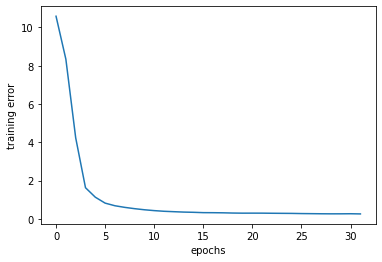

In [200]:
# epoch에 따른 training error
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training error')

In [201]:
# 모델 테스트 및 평가
model.evaluate([test.userid, test.problemid], test.rating)

2/2 [==============================] - 0s 8ms/step - loss: 2.1061 - mse: 2.1061


[2.106090784072876, 2.106090784072876]

In [202]:
# 모델이 출력하는 결과
predictions = model.predict([test.userid.head(10), test.problemid.head(10)])
for p, t in zip(predictions, test.rating.values[:10]):
    print("예측값:", p, "테스트 데이터:", t)

1/1 [==============================] - 0s 78ms/step
예측값: [2.5101771] 테스트 데이터: 5
예측값: [4.384196] 테스트 데이터: 5
예측값: [3.8375988] 테스트 데이터: 3
예측값: [1.9803282] 테스트 데이터: 1
예측값: [1.9023476] 테스트 데이터: 1
예측값: [3.8974738] 테스트 데이터: 1
예측값: [4.021108] 테스트 데이터: 4
예측값: [2.1687682] 테스트 데이터: 3
예측값: [2.777056] 테스트 데이터: 1
예측값: [2.5623746] 테스트 데이터: 1


# 결론
    - 데이터가 적어서 그런지 모델의 정확도가 많이 높지는 않다
    - 다음에 또 만들게 된다면 데이터를 충분히 모아서 하는 게 좋을 것 같다
    - 그래도 대부분 유저가 몇 번째로 푸는 게 적절하게 판단하였다